In [421]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.optim import SGD

import lightning as L
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns

In [422]:
w = 0.7
b = 0.2

In [423]:
class BasicLightning(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False )
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False )
        
        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False )
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False )
        
        self.final_bias = nn.Parameter(torch.tensor(-16.0),requires_grad=False)
        
    def forward(self,input): 
        input_to_top = input* self.w00 + self.b00
        top_relu_output = F.relu(input_to_top)
        
        scaled_top_relu = top_relu_output*self.w01
        
        input_to_bottom = input* self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom)
        
        scaled_bottom_relu = bottom_relu_output*self.w11
        
        input_to_final_relu = scaled_bottom_relu +scaled_top_relu +self.final_bias 
        output = F.relu(input_to_final_relu)
        
        return output
        

In [424]:
input_doses = torch.linspace(start=0, end=1 , steps=11)
input_doses

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

In [425]:
model = BasicLightning()

In [426]:
output = model(input_doses)
output

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0100, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])

Text(0.5, 0, 'doses')

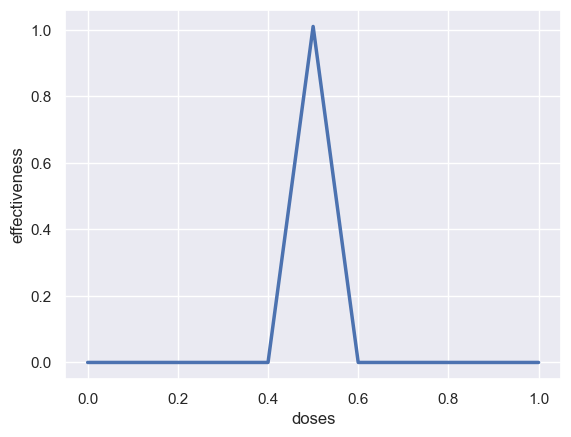

In [427]:
sns.set_theme('notebook')
sns.lineplot(x=input_doses.numpy(), y=output.detach().numpy(), linewidth=2.5)
plt.ylabel('effectiveness')
plt.xlabel('doses')

In [428]:
class BasicLightningTrain(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False )
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False )
        
        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False )
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False )
        
        self.final_bias = nn.Parameter(torch.tensor(0.),requires_grad=True)
        self.learning_rate = 0.1
        
    def forward(self,input):  
        input_to_top = input* self.w00 + self.b00
        top_relu_output = F.relu(input_to_top)
        
        scaled_top_relu = top_relu_output*self.w01
        
        input_to_bottom = input* self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom)
        
        scaled_bottom_relu = bottom_relu_output*self.w11
        
        input_to_final_relu = scaled_bottom_relu +scaled_top_relu +self.final_bias 
        output = F.relu(input_to_final_relu)
        
        return output
    
    def configure_optimizers(self):
        return SGD(self.parameters(), lr = self.learning_rate)
    
    def training_steps(self,batch,batch_idx):
        input_i , label_i = batch
        output_i = self.forward(input_i)
        loss = (output_i - label_i)**2
        
        return loss
    
    
        

In [429]:
inputs = torch.tensor([0., .5, 1.])
labels = torch.tensor([0., 1., 0.])

In [430]:
dataset = TensorDataset(inputs,labels)
dataloader = DataLoader(dataset=dataset)

In [431]:
dataloader

In [432]:
model1 = BasicLightningTrain()

In [433]:
from lightning.pytorch import Trainer

In [434]:
trainer = Trainer(max_epochs=34)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [435]:
from lightning.pytorch.tuner.tuning import Tuner

tuner = Tuner(trainer)

lrfinder = tuner.lr_find(model=model1, dataloaders=dataloader, min_lr=0.01, max_lr=1, early_stop_threshold=None)

MisconfigurationException: In tuner with method='fit', `dataloaders` argument should be None, please consider setting `train_dataloaders` and `val_dataloaders` instead.